In [1]:
import time
from multiprocessing import Pool

from IPython.display import display

import sympy

from pylab import *
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

from itertools import cycle
lstyle = cycle(('-', '--', ':', '-.',\
    (0, (1, 10)), (0, (5, 10)),\
    (0, (5, 5)), (0, (3, 10, 1, 10)),\
    (0, (3, 5, 1, 5)), \
    (0, (3, 5, 1, 5, 1, 5))))
color = cycle(('#1f77b4', '#ff7f0e', '#2ca02c',\
    '#d62728', '#9467bd', '#8c564b', '#e377c2',\
    '#7f7f7f', '#bcbd22', '#17becf'))


from scipy.sparse import *
from scipy.sparse.linalg import spsolve

In [2]:
t, x = sympy.symbols('t x', real=True)
u = sympy.symbols('u', cls=sympy.Function)(t, x)
f2, f3 = sympy.symbols('f2 f3', real=True)
eq = u.diff(t) + (f2*u**2 + f3*u**3).diff(x) + u.diff(x,3)
eq

2*f2*u(t, x)*Derivative(u(t, x), x) + 3*f3*u(t, x)**2*Derivative(u(t, x), x) + Derivative(u(t, x), t) + Derivative(u(t, x), (x, 3))

Точное решение
\begin{equation}
 \phi^{(1)} = \phi^{(2)} = \dfrac{\sigma_0}{2 \sigma_1} \pm \dfrac{k}{\sqrt{\sigma_1}} \mathrm{th}\left(
k \left(\eta + \left(2 k^2 -\dfrac{3\sigma_0^2}{2\sigma_1}\right)  t\right) \right) \tag{1.58}
\end{equation} 

In [3]:
s0, s1, k = sympy.symbols('s0, s1, k', real=True)
ex1p = s0/(2*s1) + k/sympy.sqrt(s1)*sympy.tanh(k*x - k*(-2*k**2+3*s0**2/(2*s1))*t)
display(ex1p)
display(eq.subs({f2: 3*s0, f3: -2*s1})\
  .subs({u: ex1p}).doit().simplify())
ex1m = s0/(2*s1) - k/sympy.sqrt(s1)*sympy.tanh(k*x - k*(-2*k**2+3*s0**2/(2*s1))*t)
display(ex1m)
display(eq.subs({f2: 3*s0, f3: -2*s1})\
  .subs({u: ex1m}).doit().simplify())

k*tanh(-k*t*(-2*k**2 + 3*s0**2/(2*s1)) + k*x)/sqrt(s1) + s0/(2*s1)

0

-k*tanh(-k*t*(-2*k**2 + 3*s0**2/(2*s1)) + k*x)/sqrt(s1) + s0/(2*s1)

0

In [4]:
def exact1_58p(x, t, k):
    assert s0 > 0. and s1 > 0.
    assert f2 == 3*s0 and f3 == -2*s1
    return s0/(2.*s1) + k/sqrt(s1)*tanh(k*x - k*(-2.*k**2+3.*s0**2/(2.*s1))*t)
def exact1_58m(x, t, k):
    assert s0 > 0. and s1 > 0.
    assert f2 == 3*s0 and f3 == -2*s1
    return s0/(2.*s1) - k/sqrt(s1)*tanh(k*x - k*(-2.*k**2+3.*s0**2/(2.*s1))*t)

Точное решение
\begin{equation}
\begin{gathered}
F = (\mp 2 D\,\sigma_1+\sigma_0), \\
 \phi^{(1)} = \phi^{(2)} = D + \frac{{k}^{2}}{F + \sqrt{F ^2\mp
 k^2\sigma_1}\,
\mathrm{cosh}\left(k \left[x - (6 D (\mp D\,\sigma_1+\sigma_0) + k^2) t\right]\right)}
\end{gathered} \tag{1.59}
\end{equation} 

In [5]:
def exact1_59m(x, t, k, D):
    assert s0 > 0. and s1 > 0.
    assert f2 == 3*s0 and f3 == -2*s1
    F = (-2*D*s1 + s0)
    return D + k**2/(F + sqrt(F**2 - k**2*s1)*cosh(k*(x - (6*D*(-D*s1 + s0) +  k**2)*t)))
def exact1_59p(x, t, k, D):
    assert s0 > 0. and s1 > 0.
    assert f2 == 3*s0 and f3 == 2*s1
    F = (2*D*s1 + s0)
    return D + k**2/(F + sqrt(F**2 + k**2*s1)*cosh(k*(x - (6*D*(D*s1 + s0) +  k**2)*t)))

Точное решение
\begin{equation}
\phi^{(1)} = \phi^{(2)} =  {k} \tanh\left(k \eta + 2k^3  t \right) \tag{1.59}
\end{equation} 

In [6]:
ex3 = k*sympy.tanh(k*x + 2*k**3*t)
display(ex3)
display(eq.subs({f2: 0, f3: -2})\
  .subs({u: ex3}).doit().expand())

k*tanh(2*k**3*t + k*x)

0

In [7]:
def exact1_62(x, t, k):
    assert s0 == 0. and s1 == 1.
    assert f2 == 0. and f3 == -2.
    return k*tanh(k*x + 2*k**3*t)

Точное решение
\begin{equation}
 \phi^{(1)} = \phi^{(2)} = \dfrac{2k^2}{\cosh^2(kx-4k^2t)} \tag{1.68}
\end{equation} 

In [8]:
ex3 = 2*k**2/sympy.cosh(k*x - 4*k**3*t)**2
display(ex3)
display(eq.subs({f2: 3, f3: 0})\
  .subs({u: ex3}).doit().simplify())

2*k**2/cosh(-4*k**3*t + k*x)**2

0

In [9]:
def exact1_63m(x, t, k, D):
    assert s0 == 0. and s1 == 1.
    assert f2 == 0. and f3 == -2.
    return D + k**2/(-2*D + sqrt(4*D**2 - k**2)*cosh(k*(x - (-6*D**2 +  k**2)*t)))
def exact1_63p(x, t, k, D):
    assert s0 == 0. and s1 == 1.
    assert f2 == 0. and f3 == 2.
    return D + k**2/(2*D + sqrt(4*D**2 + k**2)*cosh(k*(x - (6*D**2 +  k**2)*t)))

In [10]:
def exact1_67(x, t, k, D):
    assert s0 > 0. and s1 == 0.
    assert f2 == 3*s0 and f3 == 0.
    return D + k**2/(2*s0*(1 + cosh(k*(x - (12*D*s0 +  k**2)*t))))

In [11]:
def exact1_68(x, t, k):
    assert s0 == 1. and s1 == 0.
    assert f2 == 3. and f3 == 0.
    return 2*k**2/cosh(k*x - 4*k**3*t)**2

Система уравнений
\begin{equation}
  \begin{split}
    \varphi_t^{(1)}&+6\sigma_0\varphi^{(1)}\varphi_\eta^{(1)}+\varphi_{\eta\eta\eta}^{(1)}\mp 
6\sigma_1{\varphi^{(1)}}^2\varphi_\eta^{(1)}+
      \varphi^{(1)}-\varphi^{(2)}=0,\\
    \varphi_t^{(2)}&+6\sigma_0\varphi^{(2)}\varphi_\eta^{(2)}+\varphi_{\eta\eta\eta}^{(2)}\mp 
6\sigma_1{\varphi^{(2)}}^2\varphi_\eta^{(2)}+
      \varphi^{(2)}-\varphi^{(1)} - \sigma \varphi^{(2)} =0.
  \end{split} \tag{1.57}
\end{equation} 

Разностная схема
\begin{equation}
\begin{gathered}
\frac{{u^{(1)}}_{j}^{n+1} -{u^{(1)}}_{j}^{n} }{\tau } +3\sigma_0\frac{({{u^{(1)}}^{2}} _{j+1}^{n+1} -
{{u^{(1)}}^{2}}_{j-1}^{n+1} )+({{u^{(1)}}^{2}} _{j+1}^{n} -{{u^{(1)}}^{2}} _{j-1}^{n} )}{4h} \mp {} \hfill \\
\mp 2\sigma_1\frac{({{u^{(1)}}^{3}} _{j+1}^{n+1} -
{{u^{(1)}}^{3}}_{j-1}^{n+1} )+({{u^{(1)}}^{3}} _{j+1}^{n} -{{u^{(1)}}^{3}} _{j-1}^{n} )}{4h} + {} \\
{} +(({u^{(1)}}_{j+2}^{n+1} -2{u^{(1)}}_{j+1}^{n+1} +2{u^{(1)}}_{j-1}^{n+1} -{u^{(1)}}_{j-2}^{n+1})+ {} \\
{} + ({u^{(1)}}_{j+2}^{n} -2{u^{(1)}}_{j+1}^{n} +2{u^{(1)}}_{j-1}^{n} -{u^{(1)}}_{j-2}^{n} ))/{4h^{3} } + {}\\
\hfill {}
 +\frac{{u^{(1)}}_{j}^{n+1} +{u^{(1)}}_{j}^{n}}{2}-\frac{{u^{(2)}}_{j}^{n+1} +{u^{(2)}}_{j}^{n}}{2}=0.\\
\frac{{u^{(2)}}_{j}^{n+1} -{u^{(2)}}_{j}^{n} }{\tau} +3\sigma_0\frac{({{u^{(2)}}^{2}} _{j+1}^{n+1} -
{{u^{(2)}}^{2}}_{j-1}^{n+1} )+({{u^{(2)}}^{2}} _{j+1}^{n} -{{u^{(2)}}^{2}} _{j-1}^{n} )}{4h} \mp {} \hfill \\
\mp 2\sigma_1\frac{({{u^{(2)}}^{3}} _{j+1}^{n+1} -
{{u^{(2)}}^{3}}_{j-1}^{n+1} )+({{u^{(2)}}^{3}} _{j+1}^{n} -{{u^{(2)}}^{3}} _{j-1}^{n} )}{4h} + {} \\
{} +(({u^{(2)}}_{j+2}^{n+1} -2{u^{(2)}}_{j+1}^{n+1} +2{u^{(2)}}_{j-1}^{n+1} -{u^{(2)}}_{j-2}^{n+1})+{} \\
{} + ({u^{(2)}}_{j+2}^{n} -2{u^{(2)}}_{j+1}^{n} +2{u^{(2)}}_{j-1}^{n} -{u^{(2)}}_{j-2}^{n} ))/{4h^{3} } - {}\\ 
\hfill {}
+\frac{{u^{(2)}}_{j}^{n+1} +{u^{(2)}}_{j}^{n}}{2} -\frac{{u^{(1)}}_{j}^{n+1} +{u^{(1)}}_{j}^{n}}{2} - \sigma\frac{{u^{(2)}}_{j}^{n+1} +{u^{(2)}}_{j}^{n}}{2}=0. 
\end{gathered} \tag{2.4}
\end{equation}

In [12]:
def solve(u10, u20, dt, dx, t1, n):
    """
    u0, U0 - начальное приближение
    dt - шаг по t
    dx - шаг по x
    t1 - конечное время
    n - число шагов по времени
    """
    N = len(u10)
    assert N == len(u20)
    assert 25 <= N
    
#     dt = 0.1*dx
    
    # вспомогательные массивы для задания разреженной матрицы
    N1 = 6*(N-4) + 4*3
    row = zeros(2*N1, dtype=int32)
    col = zeros(2*N1, dtype=int32)
    data = zeros(2*N1, dtype=float64)

    # столбец свободных членов
    b = zeros(2*N, dtype=float64)

    # за нормировку строк матрицы взято dt/dx = O(1)

    # граничные условия в точке x[0]
    row.flat[:3] = 0
    col.flat[:3] = 0, 2, 3
    data.flat[:3] = -5., 9., -4.
    b[0] = 0.
    row.flat[N1:N1+3] = N
    col.flat[N1:N1+3] = N, N+2, N+3
    data.flat[N1:N1+3] = -5., 9., -4.
    b[N] = 0.

    # граничные условия в точке x[1]
    row.flat[3:6] = 1
    col.flat[3:6] = 1, 2, 3
    data.flat[3:6] = -5., 8., -3.
    b[1] = 0.
    row.flat[N1+3:N1+6] = N+1
    col.flat[N1+3:N1+6] = N+1, N+2, N+3
    data.flat[N1+3:N1+6] = -5., 8., -3.
    b[N+1] = 0.

    # граничные условия в точке x[-2]
    row.flat[N1-6:N1-3] = N-2
    col.flat[N1-6:N1-3] = N-2, N-3, N-4
    data.flat[N1-6:N1-3] = -5., 8., -3.
    b[N-2] = 0.
    row.flat[-6:-3] = 2*N-2
    col.flat[-6:-3] = 2*N-2, 2*N-3, 2*N-4
    data.flat[-6:-3] = -5., 8., -3.
    b[-2] = 0.

    # граничные условия в точке x[-1]
    row.flat[N1-3:N1] = N-1
    col.flat[N1-3:N1] = N-1, N-3, N-4
    data.flat[N1-3:N1] = -5., 9., -4.
    b[N-1] = 0.
    row.flat[-3:] = 2*N-1
    col.flat[-3:] = 2*N-1, 2*N-3, 2*N-4
    data.flat[-3:] = -5., 9., -4.
    b[-1] = 0.
    
    # задание неизменных элементов матрицы
    # (ответственны за линейные члены)
    for i in range(2, N-2):
        row.flat[6*(i-2) + 6: 6*(i-1) + 6] = i
        col.flat[6*(i-2) + 6: 6*(i-1) + 5] = range(i - 2, i + 3)
        col.flat[6*(i-1) + 5] = N + i
        row.flat[N1+6*(i-2) + 6: N1+6*(i-1) + 6] = N + i
        col.flat[N1+6*(i-2) + 6: N1+6*(i-1) + 5] = range(N + i - 2, N + i + 3)
        col.flat[N1 + 6*(i-1) + 5] = i

    data.flat[6:N1-6:6] = -dt/(4.*dx**3)
    data.flat[8:N1-6:6] = 1. + dt/2.
    data.flat[10:N1-6:6] = dt/(4.*dx**3)
    data.flat[11:N1-6:6] = -dt/2.
    data.flat[N1+6:-6:6] = -dt/(4.*dx**3)
    data.flat[N1+8:-6:6] = 1. + dt/2.*(1.-sigma)
    data.flat[N1+10:-6:6] = dt/(4.*dx**3)
    data.flat[N1+11:-6:6] = -dt/2.

    # начальное условие, накопление промежуточных решений
    # с шагом по времени k*dt и в количестве n
    u, sol1, sol2, k = concatenate((u10, u20)),\
                       [(0.0, u10, zeros_like(u10))],\
                       [(0.0, u20, zeros_like(u20))], int(t1/dt)//n
    print(dt, t1, int(t1/dt), k)
    assert k > 6
    for i in range(1, int(t1/dt)):
        # начало простой итерации для построения v решения для следующего временного слоя
        v, f, j = copy(u), True, 0
        while f:
            # задание переменных элементов матрицы
            # (ответственны за нелинейные члены)
            data.flat[7:N1-6:6] = dt/dx*(-f2*v[1:N-3]/2. \
              - f3*v[1:N-3]**2*(3./4.) + 2./(4.*dx**2))
            data.flat[9:N1-6:6] = dt/dx*(f2*v[3:N-1]/2. \
              + f3*v[3:N-1]**2*(3./4.) - 2./(4.*dx**2))
            data.flat[N1+7:-6:6] = dt/dx*(-f2*v[N+1:-3]/2. \
              - f3*v[N+1:-3]**2*(3./4.) + 2./(4.*dx**2))
            data.flat[N1+9:-6:6] = dt/dx*(f2*v[N+3:-1]/2. \
              + f3*v[N+3:-1]**2*(3./4.) - 2./(4.*dx**2))
            # вычисление правой части
            b.flat[2:N-2] = u[2:N-2] + dt/dx*(\
              + f2*(v[3:N-1]**2 - v[1:N-3]**2)/4.\
              - f2*(u[3:N-1]**2 - u[1:N-3]**2)/4.\
              + f3*(v[3:N-1]**3 - v[1:N-3]**3)/2.\
              - f3*(u[3:N-1]**3 - u[1:N-3]**3)/4.\
              - (u[4:N] - 2.*u[3:N-1] + 2.*u[1:N-3] - u[:N-4])/(4.*dx**2))\
              - (u[2:N-2] - u[N+2:-2])*(dt/2.)
            b.flat[N+2:-2] = u[N+2:-2] + dt/dx*(\
              + f2*(v[N+3:-1]**2 - v[N+1:-3]**2)/4.\
              - f2*(u[N+3:-1]**2 - u[N+1:-3]**2)/4.\
              + f3*(v[N+3:-1]**3 - v[N+1:-3]**3)/2.\
              - f3*(u[N+3:-1]**3 - u[N+1:-3]**3)/4.\
              - (u[N+4:] - 2.*u[N+3:-1] + 2.*u[N+1:-3] - u[N:-4])/(4.*dx**2))\
              - (u[N+2:-2]*(1.-sigma) - u[2:N-2])*(dt/2.)
            # решение разреженной системы линейных уравнений
            v1 = spsolve(csr_matrix((data, (row, col)), shape=(2*N, 2*N)), b)
            # условие выхода из простой итерации
            f = norm(v - v1) > 1.e-9
            v = v1
            j += 1
        u = v
        # накопление промежуточных решений
        if i > 3 and 0 <= (i + 3) % k <= 6:
            if (i + 3) % k == 0:
                fi1, fi2 = [u[:N]], [u[N:]]
            elif (i + 3) % k != 6:
                fi1.append(u[:N])
                fi2.append(u[N:])
            else:
                fi1.append(u[:N])
                fi2.append(u[N:])
                assert (i + 3) % k == 6
                assert len(fi1) == 7 and len(fi2) == 7
                print(j, end=" ") # вывод числа итераций
                fi1_x, fi1_xx = zeros_like(fi1[3]), zeros_like(fi1[3])
                fi2_x, fi2_xx = zeros_like(fi2[3]), zeros_like(fi2[3])
                
                fi1_x[1:-1] = (-fi1[3][:-2] + fi1[3][2:])/(2*dx)
                fi1_xx[0] = (2*fi1[3][0] - 5*fi1[3][1] + 4*fi1[3][2] - fi1[3][3])/dx**2
                fi1_xx[1:-1] = (fi1[3][:-2] - 2*fi1[3][1:-1] + fi1[3][2:])/dx**2
                fi1_xx[-1] = (2*fi1[3][-1] - 5*fi1[3][-2] + 4*fi1[3][-3] - fi1[3][-4])/dx**2
                
                fi1_t = (-fi1[2] + fi1[4])/(2*dt)
                fi1_tt = (fi1[2] - 2*fi1[3] + fi1[4])/dt**2
                fi1_ttt = (-fi1[1]/2 + fi1[2] - fi1[4] + fi1[5]/2)/dt**3
                fi1_tttt =  (fi1[1] - 4*fi1[2] + 6*fi1[3] - 4*fi1[4]\
                             + fi1[5])/dt**4
                fi1_ttttt = (-fi1[0] + 4*fi1[1] - 5*fi1[2] + 5*fi1[4]\
                             - 4*fi1[5] + fi1[6])/(2*dt**5)
                
                fi2_x[1:-1] = (-fi2[3][:-2] + fi2[3][2:])/(2*dx)
                fi2_xx[0] = (2*fi2[3][0] - 5*fi2[3][1] + 4*fi2[3][2] - fi2[3][3])/dx**2
                fi2_xx[1:-1] = (fi2[3][:-2] - 2*fi2[3][1:-1] + fi2[3][2:])/dx**2
                fi2_xx[-1] = (2*fi2[3][-1] - 5*fi2[3][-2] + 4*fi2[3][-3] - fi2[3][-4])/dx**2
                
                fi2_t = (-fi2[2] + fi2[4])/(2*dt)
                fi2_tt = (fi2[2] - 2*fi2[3] + fi2[4])/dt**2
                fi2_ttt = (-fi2[1]/2 + fi2[2] - fi2[4] + fi2[5]/2)/dt**3
                fi2_tttt =  (fi2[1] - 4*fi2[2] + 6*fi2[3] - 4*fi2[4]\
                             + fi2[5])/dt**4
                fi2_ttttt = (-fi2[0] + 4*fi2[1] - 5*fi2[2] + 5*fi2[4]\
                             - 4*fi2[5] + fi2[6])/(2*dt**5)

                sol1.append((i*dt, fi1[3], dt**2*fi1_ttt/12 + dx**2*(\
                    -6*fi1[3]**4*fi1_x*s1**2 - 12*fi1[3]**3*fi1_x*s0*s1\
                    - fi1[3]**3*s1 + fi1[3]**2*fi2[3]*s1 - fi1[3]**2*fi1_t*s1\
                    - 6*fi1[3]**2*fi1_x*s0**2 - fi1[3]**2*s0 + fi1[3]*fi2[3]*s0\
                    - fi1[3]*fi1_t*s0 + 6*fi1[3]*fi1_xx*fi1_x*s1 + fi1_ttttt/48\
                    + 3*fi1_xx*fi1_x*s0 + 2*fi1_x**3*s1)))
                sol2.append((i*dt, fi2[3], dt**2*fi2_ttt/12 + dx**2*(\
                    fi1[3]*fi2[3]**2*s1 + fi1[3]*fi2[3]*s0\
                    - 6*fi2[3]**4*fi2_x*s1**2 - 12*fi2[3]**3*fi2_x*s0*s1\
                    - fi2[3]**3*sigma*s1 - fi2[3]**3*s1 - fi2[3]**2*fi2_t*s1\
                    - 6*fi2[3]**2*fi2_x*s0**2 - fi2[3]**2*sigma*s0 - fi2[3]**2*s0\
                    - fi2[3]*fi2_t*s0 + 6*fi2[3]*fi2_xx*fi2_x*s1 + fi2_ttttt/48\
                    + 3*fi2_xx*fi2_x*s0 + 2*fi2_x**3*s1)))
    return sol1, sol2

In [13]:
def drawN(T, sol1, sol2, eqref, name=""):
    figure(figsize=(15.0, 4.0))
    splt1 = subplot(1, 2, 1)
    ylabel(r'$\|\varphi^{(1)} - (%s)\|_{\max}$' % eqref, {'fontsize': 18})
    setp(splt1.get_xticklabels(), visible=True)
    xlabel(r'$t$', {'fontsize': 18})
    grid(True)
    splt2 = subplot(1, 2, 2, sharex=splt1, sharey=splt1)
    ylabel(r'$\|\varphi^{(2)} - (%s)\|_{\max}$' % eqref, {'fontsize': 18})
    xlabel(r'$t$', {'fontsize': 18})
    grid(True)
    splt1.semilogy(T[1:], sol1[1:])
    splt2.semilogy(T[1:], sol2[1:])
    if name: savefig(name)
    else: show()
    close()

def draw(sol1, sol2, name=""):
    figure(figsize=(15.0, 8.0))
    splt1 = subplot(2, 2, 1)
    ylabel(r'$\varphi^{(1)}$', {'fontsize': 14})
    xlabel(r'$\eta$', {'fontsize': 14})
    setp(splt1.get_xticklabels(), visible=True)
    grid(True)
    splt1err = subplot(2, 2, 3)
    ylabel(r'$FDA$', {'fontsize': 14})
    xlabel(r'$\eta$', {'fontsize': 14})
    grid(True)

    splt2 = subplot(2, 2, 2, sharex=splt1, sharey=splt1)
    ylabel(r'$\varphi^{(2)}$', {'fontsize': 14})
    xlabel(r'$\eta$', {'fontsize': 14})
    grid(True)
    
    splt2err = subplot(2, 2, 4, sharex=splt1, sharey=splt1err)
    ylabel(r'$FDA$', {'fontsize': 14})
    xlabel(r'$\eta$', {'fontsize': 14})
    grid(True)
    
    res1, res2 = [], []
    for t, u, err in sol1: 
        splt1.plot(x, u, label="$t=%.2f$" % t)
#         splt1err.plot(x, abs(err)/(1+abs(u)), label="$t=%.2f$" % t)
        splt1err.plot(x, err, label="$t=%.2f$" % t)
        if t > 0.:
            res1.append(norm(err, ord=inf))
    for t, u, err in sol2: 
        splt2.plot(x, u, label="$t=%.2f$" % t)
#         splt2err.plot(x, abs(err)/(1+abs(u)), label="$t=%.2f$" % t)
        splt2err.plot(x, err, label="$t=%.2f$" % t)
        if t > 0.:
            res2.append(norm(err, ord=inf))
    splt1.legend(loc='best', fancybox=True)
    splt1err.legend(loc='upper left', fancybox=True)
    splt2.legend(loc='best', fancybox=True)
    splt2err.legend(loc='upper left', fancybox=True)
    y0, y1 = ylim()
    ylim(y0 - (y1-y0)*.05, y1 + (y1-y0)*.05)
    #print(ylim())
    print(res1)
    print(res2)
    if name: savefig(name)
    else: show()
    close()

def draw1(sol1, sol2, exact, name=""):
    figure(figsize=(15.0, 8.0))
    
    splt1 = subplot(3, 2, 1)
    ylabel(r'$\varphi^{(1)}$', {'fontsize': 14})
    xlabel(r'$\eta$', {'fontsize': 14})
    setp(splt1.get_xticklabels(), visible=True)
    grid(True)

    splt1FDA = subplot(3, 2, 3)
    ylabel(r'$FDA$', {'fontsize': 14})
    xlabel(r'$\eta$', {'fontsize': 14})
    grid(True)
    
    splt1err = subplot(3, 2, 5)
    ylabel(r'$error$', {'fontsize': 14})
    xlabel(r'$\eta$', {'fontsize': 14})
    grid(True)
    
    splt2 = subplot(3, 2, 2, sharex=splt1, sharey=splt1)
    ylabel(r'$\varphi^{(2)}$', {'fontsize': 14})
    xlabel(r'$\eta$', {'fontsize': 14})
    grid(True)
    
    splt2FDA = subplot(3, 2, 4)
    ylabel(r'$FDA$', {'fontsize': 14})
    xlabel(r'$\eta$', {'fontsize': 14})
    grid(True)

    splt2err = subplot(3, 2, 6)
    ylabel(r'$error$', {'fontsize': 14})
    xlabel(r'$\eta$', {'fontsize': 14})
    grid(True)
    
    res1, res2 = [], []
    for t, u, err in sol1: 
        splt1.plot(x, u, label="$t=%.2f$" % t)
#         splt1err.plot(x, abs(err)/(1+abs(u)), label="$t=%.2f$" % t)
        splt1FDA.plot(x, err, label="$t=%.2f$" % t)
        splt1err.plot(x, exact[0](*([x, t] + exact[1:])) - u, label="$t=%.2f$" % t)
        if t > 0.:
            res1.append(norm(err, ord=inf)/norm(exact[0](*([x, t] + exact[1:])) - u, ord=inf))
    for t, u, err in sol2: 
        splt2.plot(x, u, label="$t=%.2f$" % t)
#         splt2err.plot(x, abs(err)/(1+abs(u)), label="$t=%.2f$" % t)
        splt2FDA.plot(x, err, label="$t=%.2f$" % t)
        splt2err.plot(x, exact[0](*([x, t] + exact[1:])) - u, label="$t=%.2f$" % t)
        if t > 0.:
            res2.append(norm(err, ord=inf)/norm(exact[0](*([x, t] + exact[1:])) - u, ord=inf))
    splt1.legend(loc='best', fancybox=True)
    splt1FDA.legend(loc='upper left', fancybox=True)
    splt1err.legend(loc='upper left', fancybox=True)
    splt2.legend(loc='best', fancybox=True)
    splt2FDA.legend(loc='upper left', fancybox=True)
    splt2err.legend(loc='upper left', fancybox=True)
    y0, y1 = ylim()
    ylim(y0 - (y1-y0)*.05, y1 + (y1-y0)*.05)
    #print(ylim())
    print(res1)
    print(res2)
    if name: savefig(name)
    else: show()
    close()

In [14]:
# размер расчетной области 0 <= x <= L и число точек на ней
L, N = 200., 4001
# отношение шагов dt/dx по времени и x 
l = 0.8 

In [15]:
s0, s1 = 1., 1.
f2, f3, sigma = 3.*s0, -2.*s1, 0.
x = array(linspace(-L*.3, L*.7, N), dtype=float64)
sol1, sol2 = solve(exact1_58p(x, 0., 0.2), exact1_58p(x, 0., 0.2), l*(x[1] - x[0]), x[1] - x[0], 50., 5)

0.03999999999999773 50.0 1250 250
3 3 3 3 

[0.04641146231952787, 0.04634154878210441, 0.046300257903683056, 0.0462741339224812]
[0.04641146874279352, 0.04634154933850047, 0.046300252201598294, 0.04627414243750484]


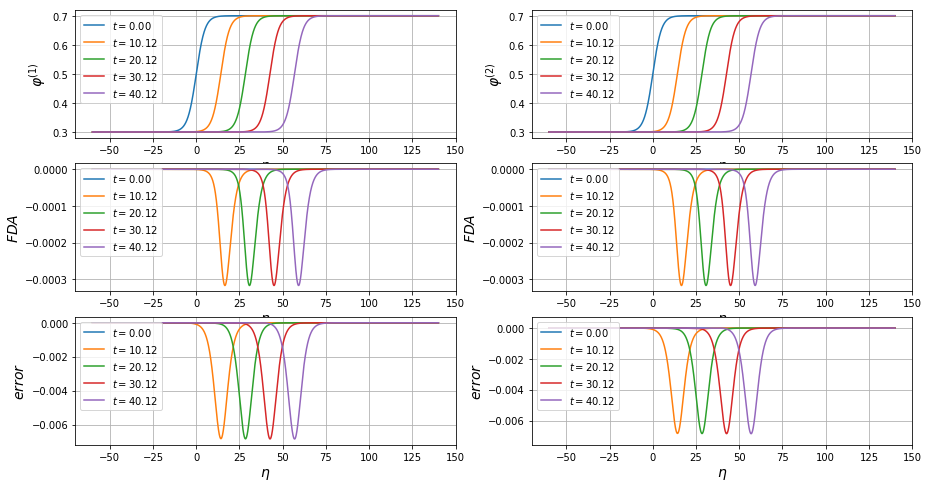

[0.04641146231952787, 0.04634154878210441, 0.046300257903683056, 0.0462741339224812]
[0.04641146874279352, 0.04634154933850047, 0.046300252201598294, 0.04627414243750484]


In [16]:
draw1(sol1, sol2, [exact1_58p, 0.2])
draw1(sol1, sol2, [exact1_58p, 0.2], "./fig_1_58p.pdf")

In [17]:
s0, s1 = 1., 1.
f2, f3, sigma = 3.*s0, -2.*s1, 1.
x = array(linspace(-L*.7, L*.3, N), dtype=float64)
print(0.5*(x[1] - x[0]))
sol1, sol2 = solve(exact1_58p(x, 0., 0.2), zeros_like(x), l*(x[1] - x[0]), x[1] - x[0], 2.5, 4)

0.025000000000005684
0.0400000000000091 2.5 62 15
3 3 3 

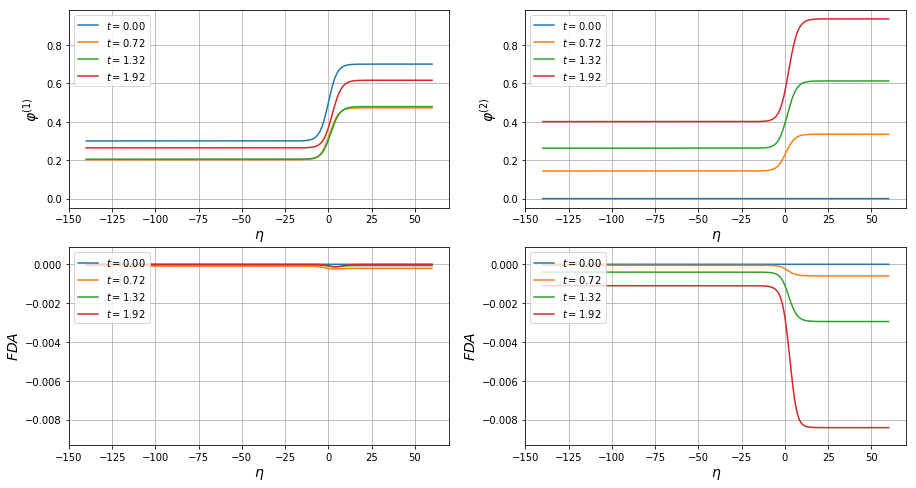

In [18]:
draw(sol1, sol2)
draw(sol1, sol2, "./fig_1_58p+1.pdf")

In [19]:
s0, s1 = 1., 1.
f2, f3, sigma = 3.*s0, -2.*s1, -1.
x = array(linspace(-L*.7, L*.3, N), dtype=float64)
sol1, sol2 = solve(exact1_58p(x, 0., 0.2), zeros_like(x), l*(x[1] - x[0]), x[1] - x[0], 3., 6)

0.0400000000000091 3.0 74 12
3 3 3 3 3 

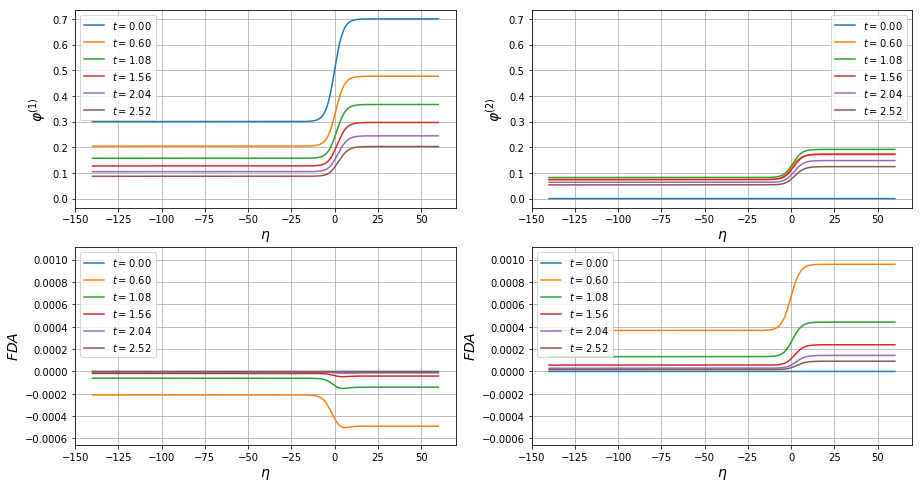

In [20]:
draw(sol1, sol2)
draw(sol1, sol2, "./fig_1_58p-1.pdf")

In [20]:
s0, s1 = 1., 1.
f2, f3, sigma = 3.*s0, -2.*s1, 0.
x = array(linspace(-L*.3, L*.7, N), dtype=float64)
sol1, sol2 = solve(exact1_58m(x, 0., 0.2), exact1_58m(x, 0., 0.2), l*(x[1] - x[0]), x[1] - x[0], 50., 6)

0.03999999999999773 50.0 1250 208
3 3 3 3 3 

[0.04643965718900387, 0.04637269093341843, 0.04632906690646389, 0.04629941740350592, 0.04627946700882135]
[0.046439657023694424, 0.04637269840290813, 0.04632907218443608, 0.04629940959712684, 0.04627944935134012]


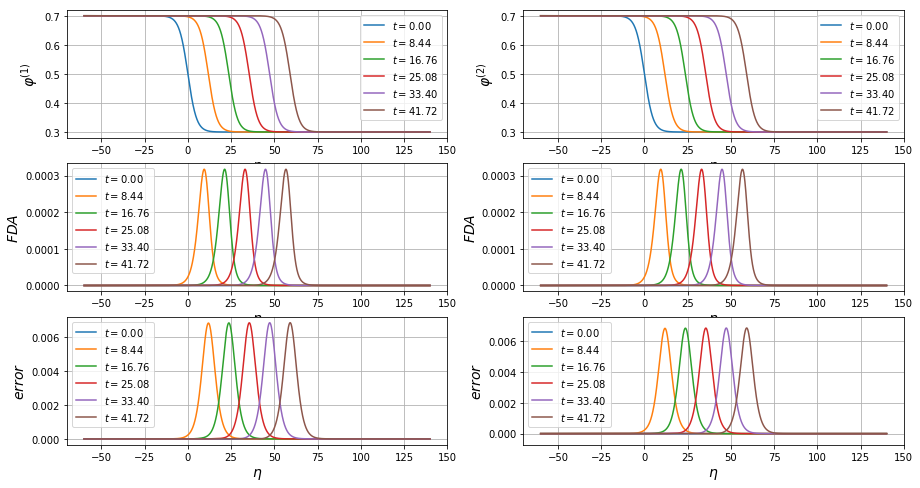

[0.04643965718900387, 0.04637269093341843, 0.04632906690646389, 0.04629941740350592, 0.04627946700882135]
[0.046439657023694424, 0.04637269840290813, 0.04632907218443608, 0.04629940959712684, 0.04627944935134012]


In [21]:
draw1(sol1, sol2, [exact1_58m, 0.2])
draw1(sol1, sol2, [exact1_58m, 0.2], "./fig_1_58m.pdf")

In [23]:
s0, s1 = 1., 1.
f2, f3, sigma = 3.*s0, -2.*s1, 1.
x = array(linspace(-L*.3, L*.7, N), dtype=float64)
sol1, sol2 = solve(exact1_58m(x, 0., 0.2), zeros_like(x), l*(x[1] - x[0]), x[1] - x[0], 2., 4)

0.03999999999999773 2.0 50 12
3 3 3 

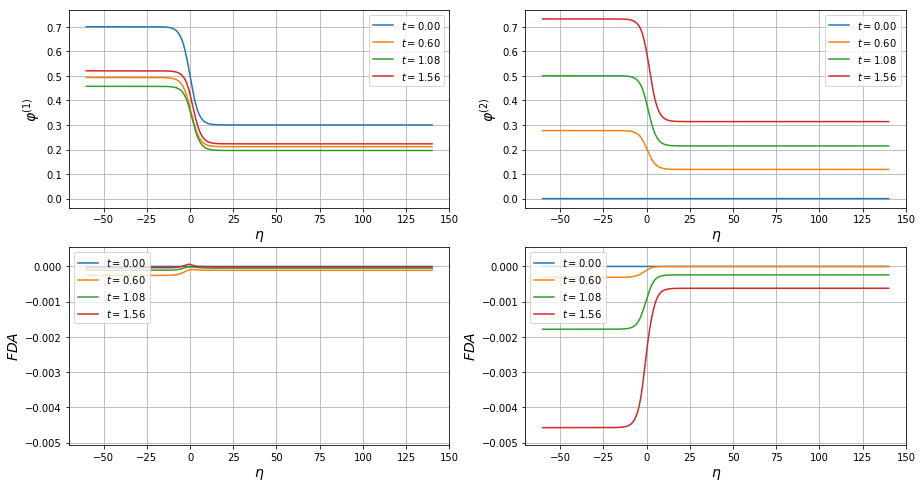

In [24]:
draw(sol1, sol2)
draw(sol1, sol2, "./fig_1_58m+1.pdf")

In [25]:
s0, s1 = 1., 1.
f2, f3, sigma = 3.*s0, -2.*s1, -1.
x = array(linspace(-L*.3, L*.7, N), dtype=float64)
sol1, sol2 = solve(exact1_58m(x, 0., 0.2), zeros_like(x), l*(x[1] - x[0]), x[1] - x[0], 5., 6)

0.03999999999999773 5.0 125 20
3 3 3 3 3 3 

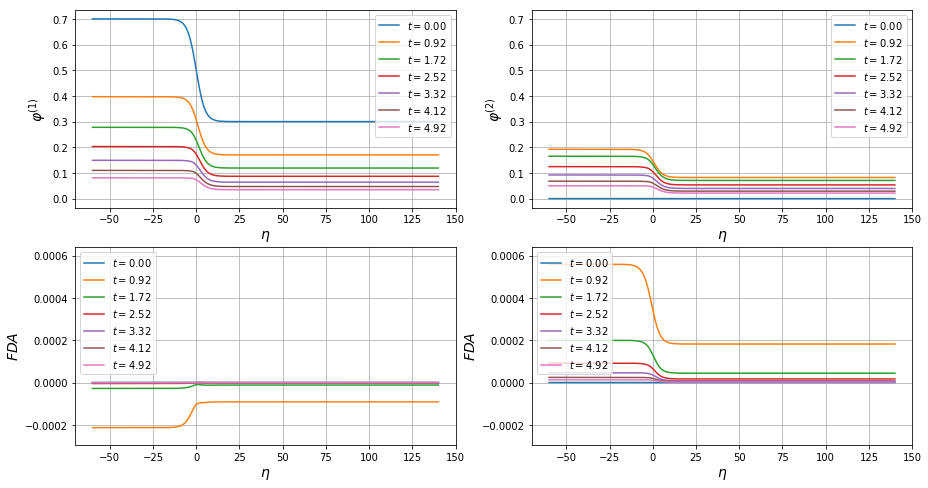

In [26]:
draw(sol1, sol2)
draw(sol1, sol2, "./fig_1_58m-1.pdf")

In [27]:
s0, s1 = 1., 1.
f2, f3, sigma = 3.*s0, 2.*s1, 0.
x = array(linspace(-L*.3, L*.7, N), dtype=float64)
D = 0.5
sol1, sol2 = solve(exact1_59p(x, 0., 0.2, D), zeros_like(x), l*(x[1] - x[0]), x[1] - x[0], 3., 6)

0.03999999999999773 3.0 75 12
3 3 3 3 3 

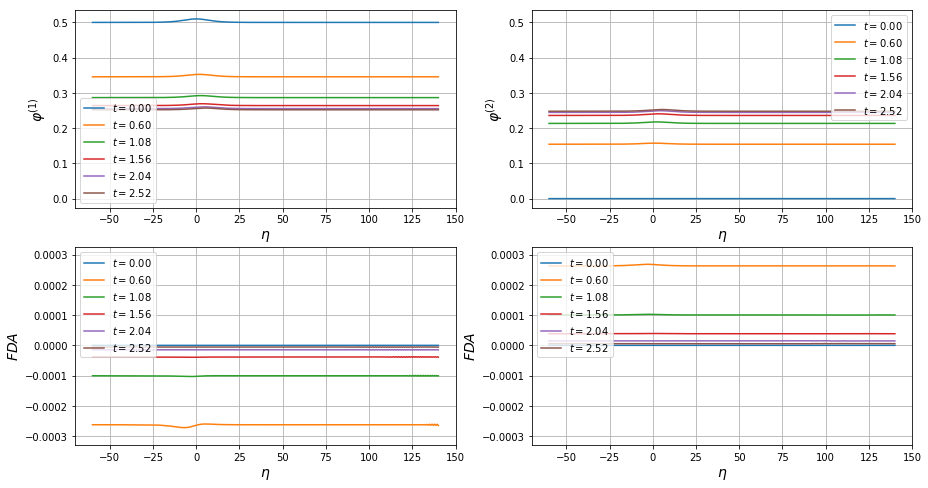

In [28]:
draw(sol1, sol2)
draw(sol1, sol2, "./fig_1_59p.pdf")

In [42]:
s0, s1 = 1., 1.
f2, f3, sigma = 3.*s0, -2.*s1, 0.
x = array(linspace(-L*.3, L*.7, N), dtype=float64)
D = 0.3
sol1, sol2 = solve(exact1_59m(x, 0., 0.2, D), exact1_59m(x, 0., 0.2, D), 3.*(x[1] - x[0]), x[1] - x[0], 60., 6)

0.14999999999999147 60.0 400 66
3 3 3 3 3 3 

[0.0024105023414743233, 0.0024007642362547776, 0.0023921218924070863, 0.0023803864279615225, 0.0023759404030904373, 0.0023662117961266806]
[0.0024105023471440888, 0.002400764229164781, 0.0023921218920889063, 0.0023803864479771254, 0.002375940391030225, 0.0023662118060722736]


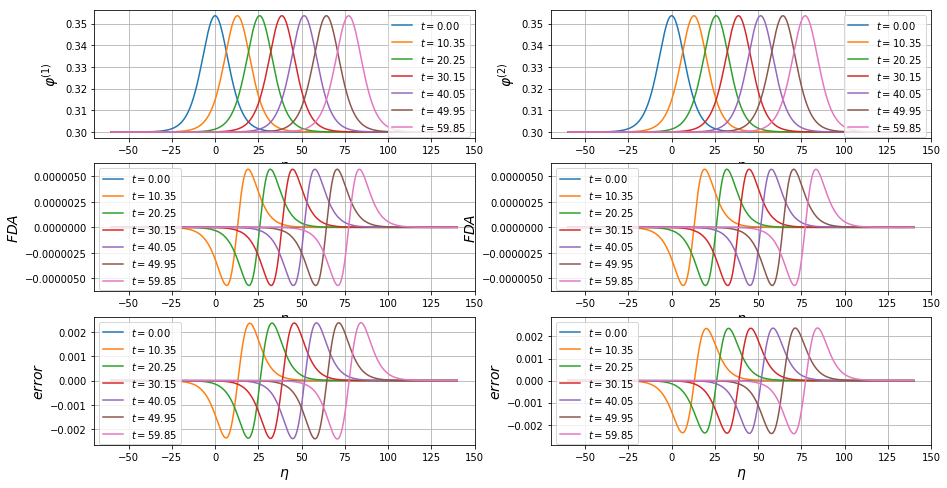

[0.0024105023414743233, 0.0024007642362547776, 0.0023921218924070863, 0.0023803864279615225, 0.0023759404030904373, 0.0023662117961266806]
[0.0024105023471440888, 0.002400764229164781, 0.0023921218920889063, 0.0023803864479771254, 0.002375940391030225, 0.0023662118060722736]


In [43]:
draw1(sol1, sol2, [exact1_59m, 0.2, D])
draw1(sol1, sol2, [exact1_59m, 0.2, D], "./fig_1_59m.pdf")

In [31]:
s0, s1 = 1., 1.
f2, f3, sigma = 3.*s0, -2.*s1, 1.
x = array(linspace(-L*.3, L*.7, N), dtype=float64)
D = 0.3
sol1, sol2 = solve(exact1_59m(x, 0., 0.2, D), zeros_like(x), l*(x[1] - x[0]), x[1] - x[0], 2., 5)

0.03999999999999773 2.0 50 10
3 3 3 3 

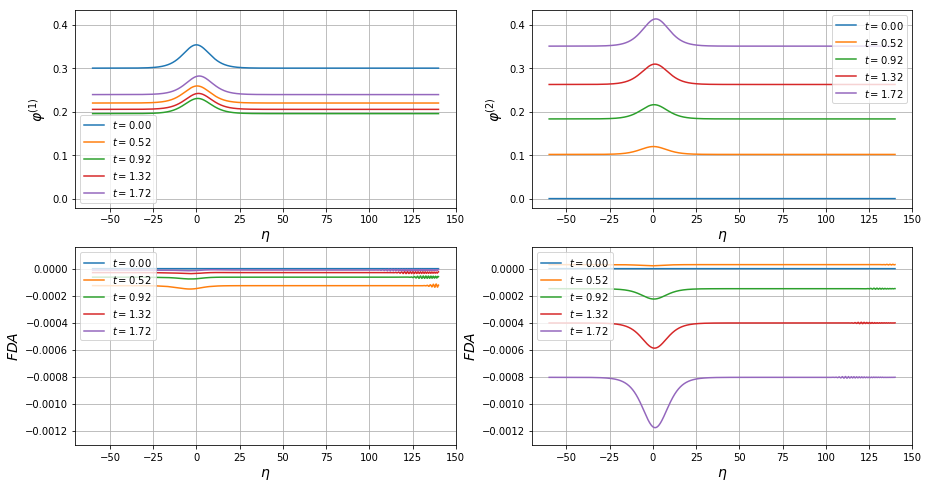

In [32]:
draw(sol1, sol2)
draw(sol1, sol2, "./fig_1_59m+1.pdf")

In [33]:
s0, s1 = 1., 1.
f2, f3, sigma = 3.*s0, -2.*s1, -1.
x = array(linspace(-L*.3, L*.7, N), dtype=float64)
D = 0.3
sol1, sol2 = solve(exact1_59m(x, 0., 0.2, D), zeros_like(x), l*(x[1] - x[0]), x[1] - x[0], 6., 6)

0.03999999999999773 6.0 150 25
3 3 3 3 3 

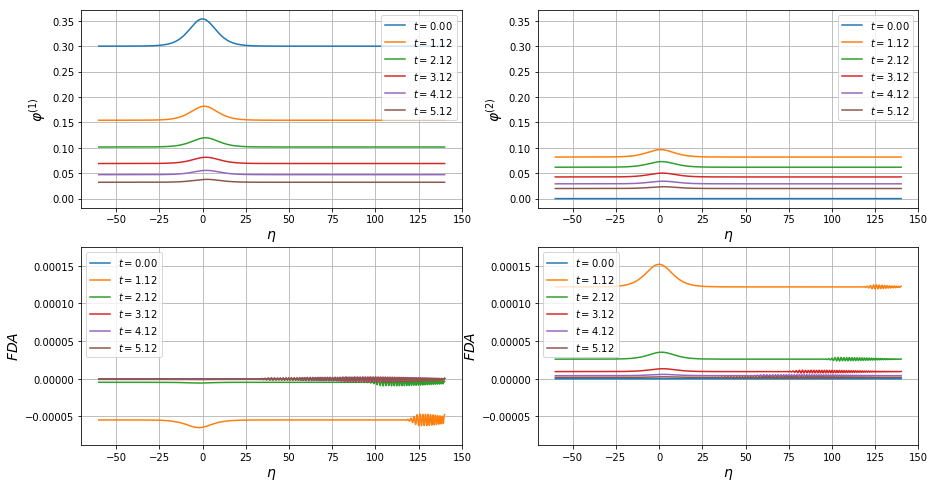

In [34]:
draw(sol1, sol2)
draw(sol1, sol2, "./fig_1_59m-1.pdf")

In [24]:
s0, s1 = 0., 1.
f2, f3, sigma = 3.*s0, -2.*s1, 0.
x = array(linspace(-L*.7, L*.3, N), dtype=float64)
sol1, sol2 = solve(exact1_62(x, 0., 0.2), exact1_62(x, 0., 0.2), l*(x[1] - x[0]), x[1] - x[0], 800., 6)

0.0400000000000091 800.0 19999 3333
2 2 2 2 2 

[0.0010376985882771398, 0.0010351390345579603, 0.0010339597744291194, 0.0010359596321824814, 0.0010349975971298282]
[0.0010379256238531186, 0.0010351286203491572, 0.0010339859703103929, 0.0010359537964894424, 0.0010350380206597828]


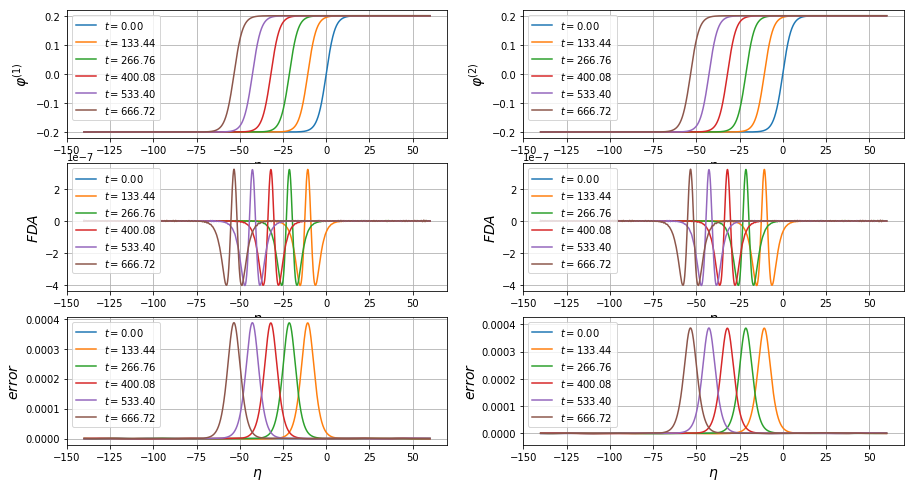

[0.0010376985882771398, 0.0010351390345579603, 0.0010339597744291194, 0.0010359596321824814, 0.0010349975971298282]
[0.0010379256238531186, 0.0010351286203491572, 0.0010339859703103929, 0.0010359537964894424, 0.0010350380206597828]


In [25]:
draw1(sol1, sol2, [exact1_62, 0.2])
draw1(sol1, sol2, [exact1_62, 0.2], "./fig_1_62.pdf")

In [37]:
s0, s1 = 0., 1.
f2, f3, sigma = 3.*s0, -2.*s1, 1.
x = array(linspace(-L*.7, L*.3, N), dtype=float64)
sol1, sol2 = solve(exact1_62(x, 0., 0.2), zeros_like(x), l*(x[1] - x[0]), x[1] - x[0], 3., 6)

0.0400000000000091 3.0 74 12
3 3 3 3 3 

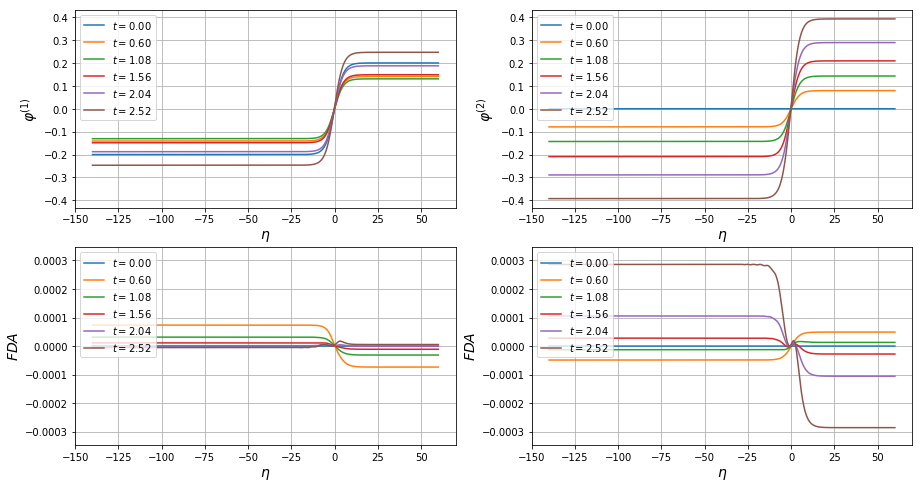

In [38]:
draw(sol1, sol2)
draw(sol1, sol2, "./fig_1_62+1.pdf")

In [39]:
s0, s1 = 0., 1.
f2, f3, sigma = 3.*s0, -2.*s1, -1.
x = array(linspace(-L*.7, L*.3, N), dtype=float64)
sol1, sol2 = solve(exact1_62(x, 0., 0.2), zeros_like(x), l*(x[1] - x[0]), x[1] - x[0], 5., 6)

0.0400000000000091 5.0 124 20
3 3 3 3 3 2 

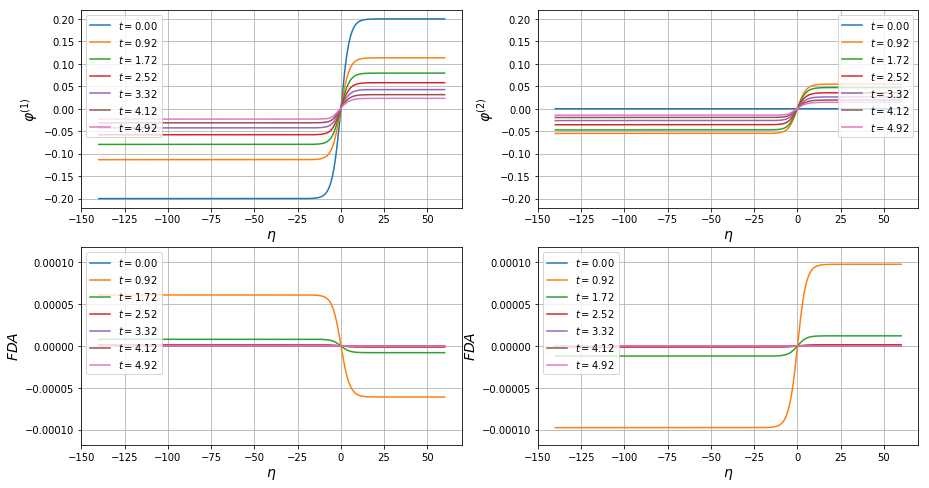

In [40]:
draw(sol1, sol2)
draw(sol1, sol2, "./fig_1_62-1.pdf")

In [26]:
s0, s1 = 0., 1.
f2, f3, sigma = 3.*s0, 2.*s1, 0.
x = array(linspace(-L*.3, L*.7, N), dtype=float64)
D = 0.5
sol1, sol2 = solve(exact1_63p(x, 0., 0.2, D), exact1_63p(x, 0., 0.2, D), l*(x[1] - x[0]), x[1] - x[0], 50., 6)

0.03999999999999773 50.0 1250 208
3 3 3 3 3 

[0.006790632446287939, 0.007107127222427446, 0.006815978512890634, 0.007239623324665899, 0.0073774282397752215]
[0.006790650166741436, 0.0071070662820333355, 0.006815897358614506, 0.007244521034467015, 0.007377655668953502]


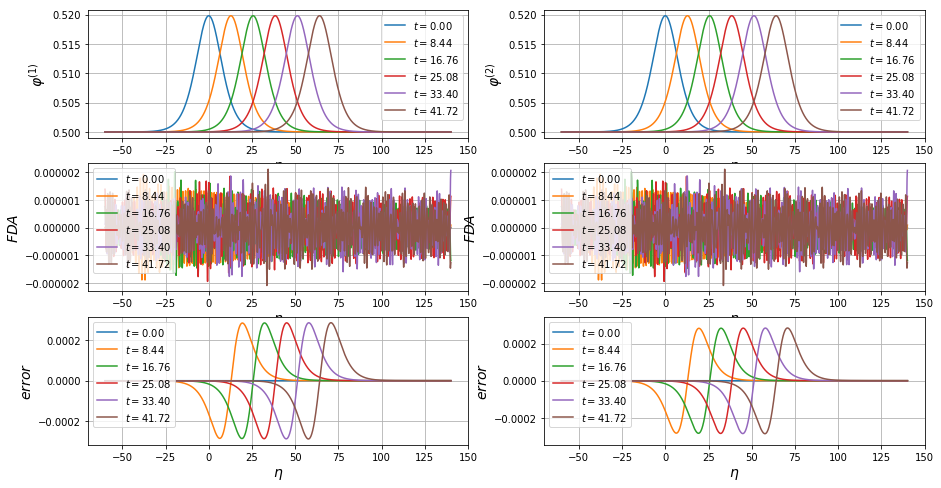

[0.006790632446287939, 0.007107127222427446, 0.006815978512890634, 0.007239623324665899, 0.0073774282397752215]
[0.006790650166741436, 0.0071070662820333355, 0.006815897358614506, 0.007244521034467015, 0.007377655668953502]


In [27]:
draw1(sol1, sol2, [exact1_63p, 0.2, D])
draw1(sol1, sol2, [exact1_63p, 0.2, D], "./fig_1_63p.pdf")

In [43]:
s0, s1 = 0., 1.
f2, f3, sigma = 3.*s0, 2.*s1, 1.
x = array(linspace(-L*.3, L*.7, N), dtype=float64)
D = 0.5
sol1, sol2 = solve(exact1_63p(x, 0., 0.2, D), zeros_like(x), l*(x[1] - x[0]), x[1] - x[0], 2., 5)

0.03999999999999773 2.0 50 10
3 3 3 3 

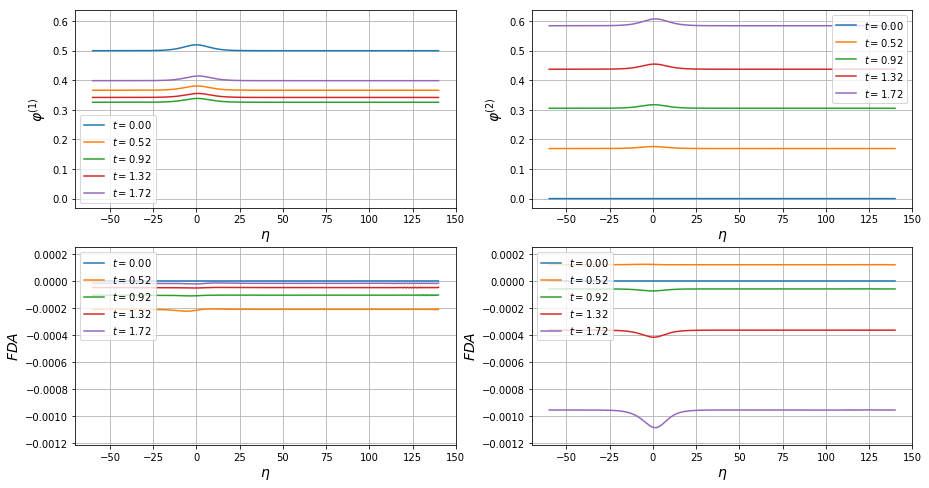

In [44]:
draw(sol1, sol2)
draw(sol1, sol2, "./fig_1_63p+1.pdf")

In [45]:
s0, s1 = 0., 1.
f2, f3, sigma = 3.*s0, 2.*s1, -1.
x = array(linspace(-L*.3, L*.7, N), dtype=float64)
D = 0.5
sol1, sol2 = solve(exact1_63p(x, 0., 0.2, D), zeros_like(x), l*(x[1] - x[0]), x[1] - x[0], 2., 5)

0.03999999999999773 2.0 50 10
3 3 3 3 

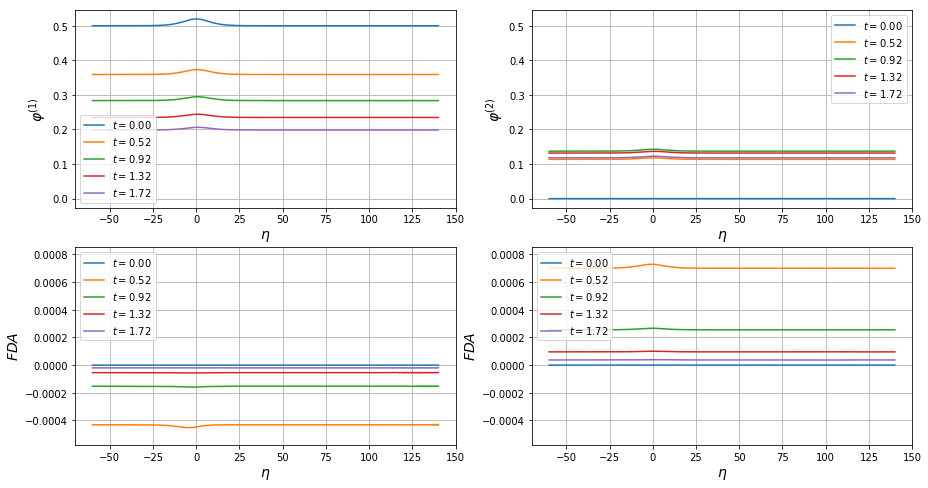

In [46]:
draw(sol1, sol2)
draw(sol1, sol2, "./fig_1_63p-1.pdf")

In [28]:
s0, s1 = 0., 1.
f2, f3, sigma = 3.*s0, -2.*s1, 0.
x = array(linspace(-L*.7, L*.3, N), dtype=float64)
D = -0.5
sol1, sol2 = solve(exact1_63m(x, 0., 0.2, D), exact1_63m(x, 0., 0.2, D), l*(x[1] - x[0]), x[1] - x[0], 50., 6)

0.0400000000000091 50.0 1249 208
3 3 3 3 3 

[0.012870355199692277, 0.014570433516722702, 0.016416162165278005, 0.014151864413152096, 0.015087084513816122]
[0.012870611179410471, 0.014570514878951517, 0.016415992205271894, 0.014151560642422657, 0.015087221438834194]


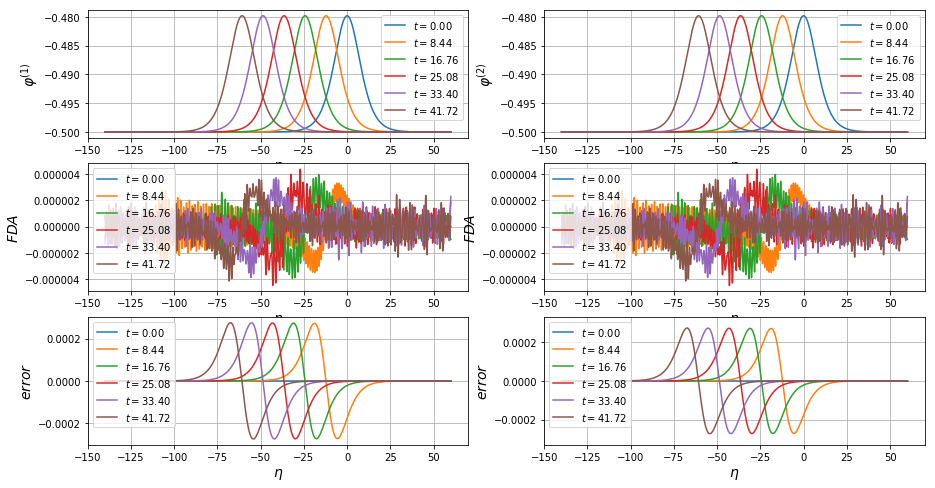

[0.012870355199692277, 0.014570433516722702, 0.016416162165278005, 0.014151864413152096, 0.015087084513816122]
[0.012870611179410471, 0.014570514878951517, 0.016415992205271894, 0.014151560642422657, 0.015087221438834194]


In [29]:
draw1(sol1, sol2, [exact1_63m, 0.2, D])
draw1(sol1, sol2, [exact1_63m, 0.2, D], "./fig_1_63m.pdf")

In [49]:
s0, s1 = 0., 1.
f2, f3, sigma = 3.*s0, -2.*s1, 1.
x = array(linspace(-L*.7, L*.3, N), dtype=float64)
D = -0.5
sol1, sol2 = solve(exact1_63m(x, 0., 0.2, D), zeros_like(x), l*(x[1] - x[0]), x[1] - x[0], 2., 5)

0.0400000000000091 2.0 49 9
3 3 3 3 3 

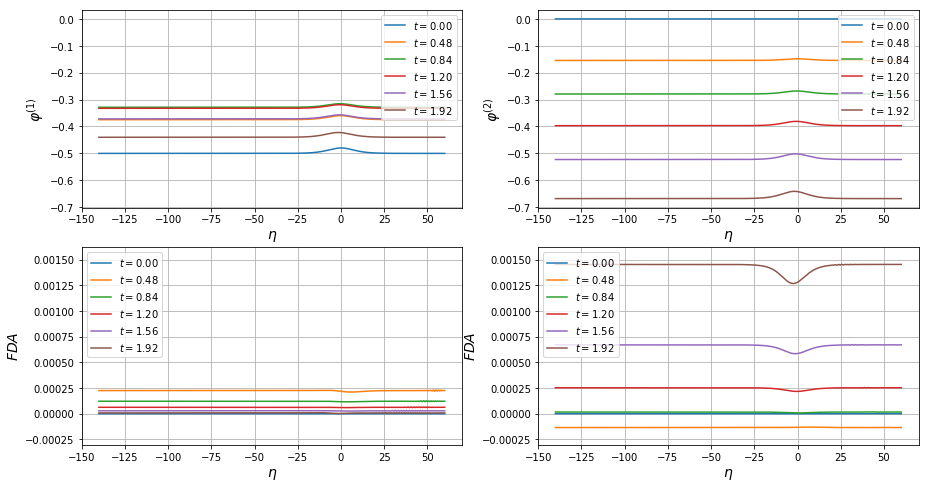

In [50]:
draw(sol1, sol2)
draw(sol1, sol2, "./fig_1_63m+1.pdf")

In [51]:
s0, s1 = 0., 1.
f2, f3, sigma = 3.*s0, -2.*s1, -1.
x = array(linspace(-L*.7, L*.3, N), dtype=float64)
D = -0.5
sol1, sol2 = solve(exact1_63m(x, 0., 0.2, D), zeros_like(x), l*(x[1] - x[0]), x[1] - x[0], 2., 5)

0.0400000000000091 2.0 49 9
3 3 3 3 3 

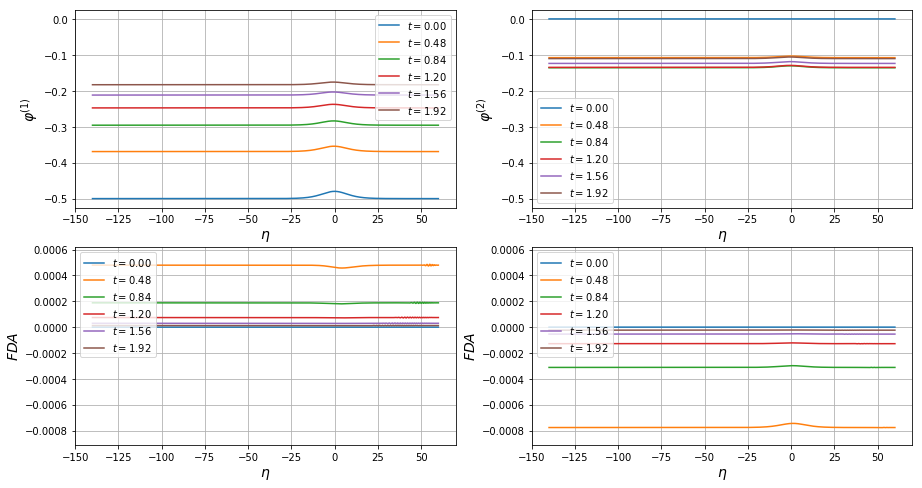

In [52]:
draw(sol1, sol2)
draw(sol1, sol2, "./fig_1_63m-1.pdf")

In [36]:
s0, s1 = 1., 0.
f2, f3, sigma = 3.*s0, -2.*s1, 0.
x = array(linspace(-L*.3, L*.7, N), dtype=float64)
D = 0.5
sol1, sol2 = solve(exact1_67(x, 0., 0.2, D), exact1_67(x, 0., 0.2, D), 3.0*(x[1] - x[0]), x[1] - x[0], 20., 6)

0.14999999999999147 20.0 133 22
3 3 3 3 3 

[0.00024792791077398097, 0.00020262799820998332, 0.00019538882844746304, 0.0001922100814758321, 0.00018897608941416966]
[0.00024792791746963444, 0.00020262800125093157, 0.00019538882737415872, 0.00019221008310652392, 0.00018897608906397065]


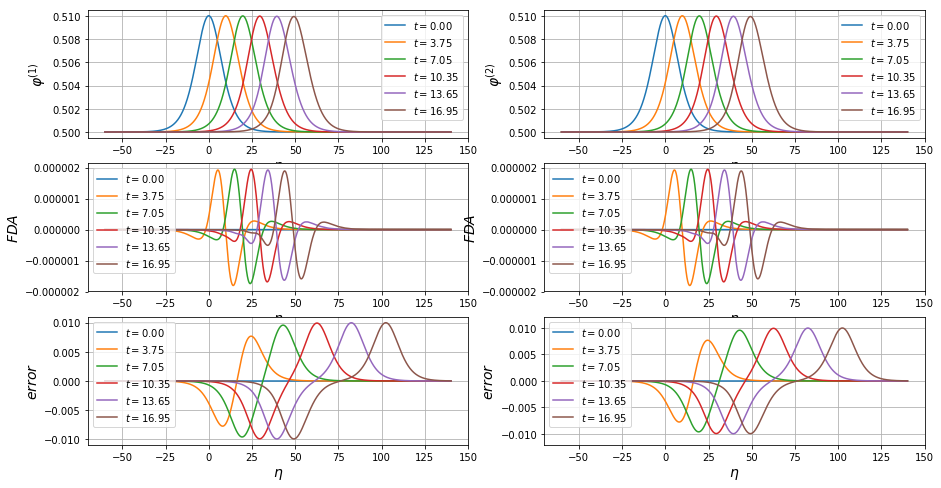

[0.00024792791077398097, 0.00020262799820998332, 0.00019538882844746304, 0.0001922100814758321, 0.00018897608941416966]
[0.00024792791746963444, 0.00020262800125093157, 0.00019538882737415872, 0.00019221008310652392, 0.00018897608906397065]


In [37]:
draw1(sol1, sol2, [exact1_67, 0.2, D])
draw1(sol1, sol2, [exact1_67, 0.2, D], "./fig_1_67.pdf")

In [55]:
s0, s1 = 1., 0.
f2, f3, sigma = 3.*s0, -2.*s1, 1.
x = array(linspace(-L*.3, L*.7, N), dtype=float64)
D = 0.5
sol1, sol2 = solve(exact1_67(x, 0., 0.2, D), zeros_like(x), l*(x[1] - x[0]), x[1] - x[0], 1.5, 4)

0.03999999999999773 1.5 37 9
3 3 3 

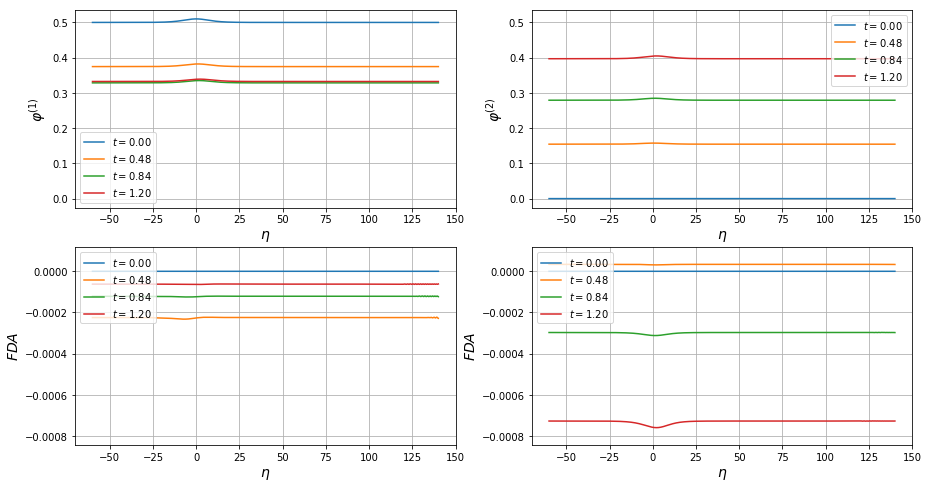

In [56]:
draw(sol1, sol2)
draw(sol1, sol2, "./fig_1_67+1.pdf")

In [57]:
s0, s1 = 1., 0.
f2, f3, sigma = 3.*s0, -2.*s1, -1.
x = array(linspace(-L*.3, L*.7, N), dtype=float64)
D = 0.5
sol1, sol2 = solve(exact1_67(x, 0., 0.2, D), zeros_like(x), l*(x[1] - x[0]), x[1] - x[0], 1.5, 4)

0.03999999999999773 1.5 37 9
3 3 3 

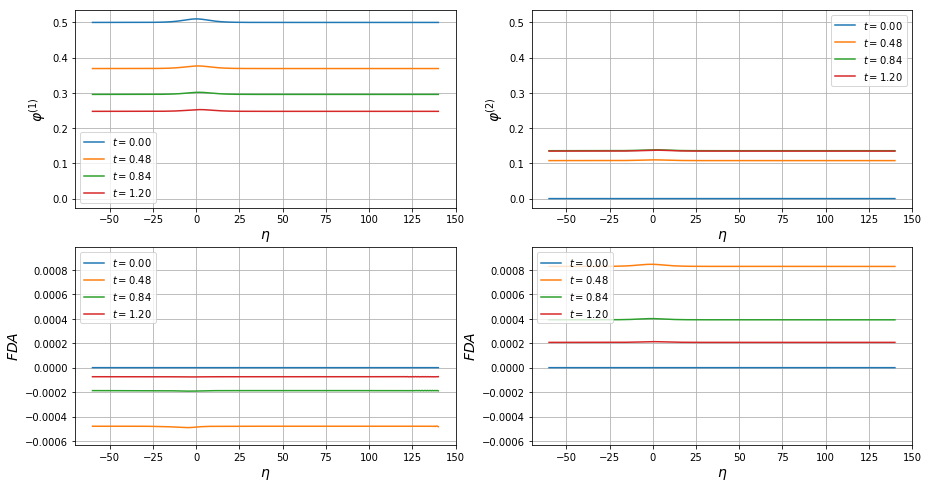

In [58]:
draw(sol1, sol2)
draw(sol1, sol2, "./fig_1_67-1.pdf")

In [40]:
s0, s1 = 1., 0.
f2, f3, sigma = 3.*s0, -2.*s1, 0.
x = array(linspace(-L*.3, L*.7, N), dtype=float64)
sol1, sol2 = solve(exact1_68(x, 0., 0.2), exact1_68(x, 0., 0.2), 3.*(x[1] - x[0]), x[1] - x[0], 500., 5)

0.14999999999999147 500.0 3333 666
3 3 3 3 

[0.0007886167710559551, 0.0007863012978493219, 0.0007838453427962625, 0.0007816075862370705]
[0.0007886167688669637, 0.0007863013008809006, 0.0007838453550435138, 0.0007816075750881499]


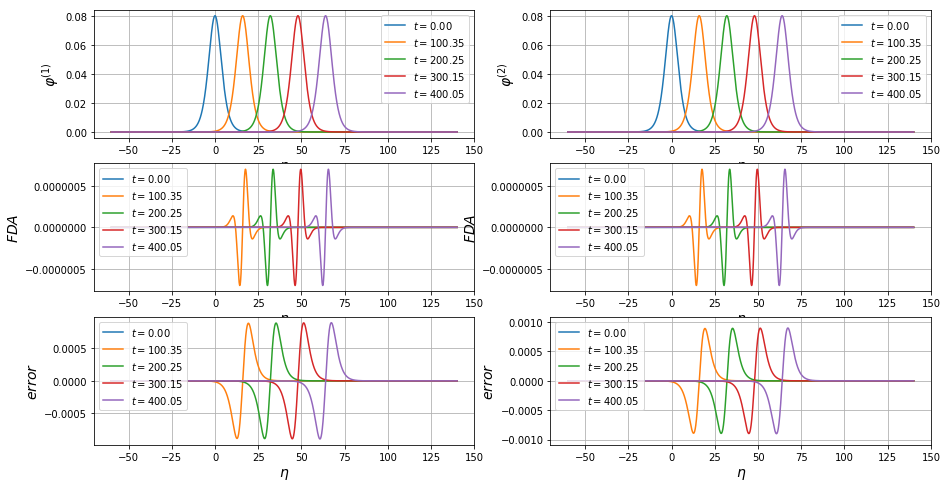

[0.0007886167710559551, 0.0007863012978493219, 0.0007838453427962625, 0.0007816075862370705]
[0.0007886167688669637, 0.0007863013008809006, 0.0007838453550435138, 0.0007816075750881499]


In [41]:
draw1(sol1, sol2, [exact1_68, 0.2])
draw1(sol1, sol2, [exact1_68, 0.2], "./fig_1_68.pdf")

In [61]:
s0, s1 = 1., 0.
f2, f3, sigma = 3.*s0, -2.*s1, 1.
x = array(linspace(-L*.3, L*.7, N), dtype=float64)
sol1, sol2 = solve(exact1_68(x, 0., 0.2), zeros_like(x), l*(x[1] - x[0]), x[1] - x[0], 3., 6)

0.03999999999999773 3.0 75 12
3 3 3 3 3 

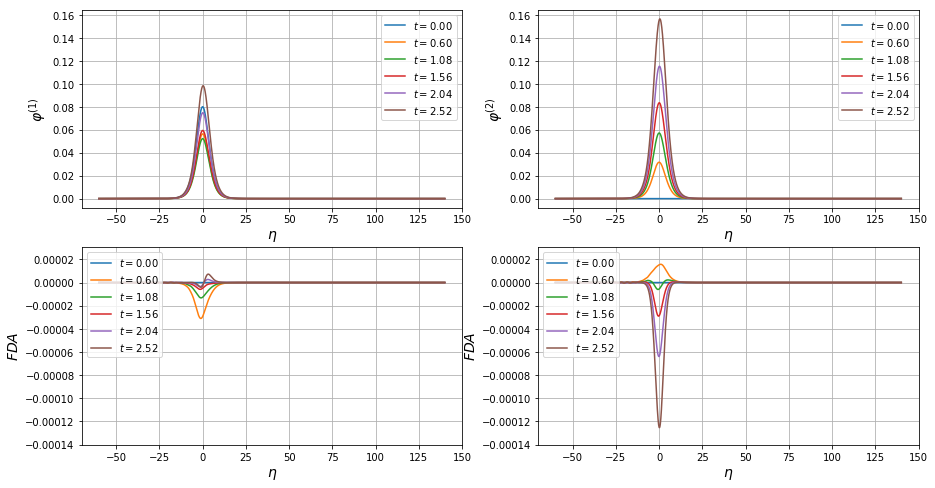

In [62]:
draw(sol1, sol2)
draw(sol1, sol2, "./fig_1_68+1.pdf")

In [63]:
s0, s1 = 1., 0.
f2, f3, sigma = 3.*s0, -2.*s1, -1.
x = array(linspace(-L*.3, L*.7, N), dtype=float64)
sol1, sol2 = solve(exact1_68(x, 0., 0.2), zeros_like(x), l*(x[1] - x[0]), x[1] - x[0], 3., 6)

0.03999999999999773 3.0 75 12
3 3 3 3 3 

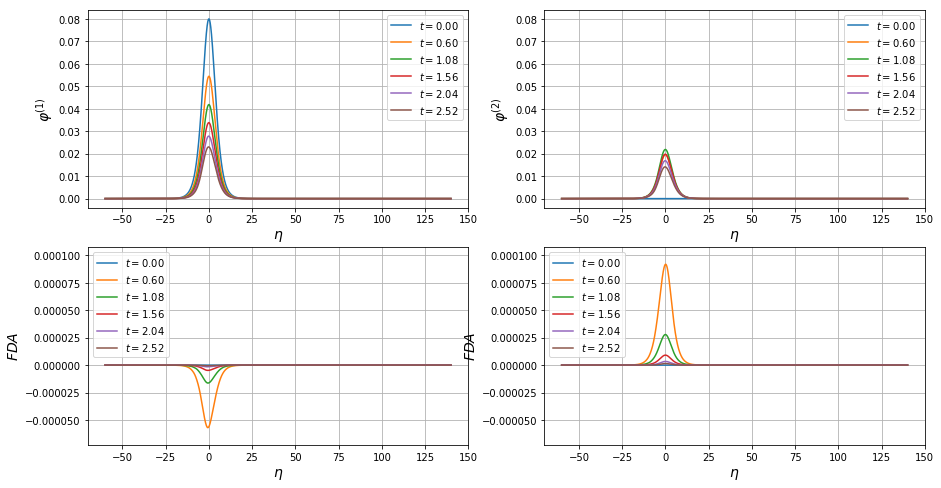

In [64]:
draw(sol1, sol2)
draw(sol1, sol2, "./fig_1_68-1.pdf")